In [1]:
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, mutual_info_classif, RFE
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
## Reading data ##
data = pd.read_csv('Data/abundance.txt', delimiter='\t', low_memory=False).T

## Labeling rows ##
df_initial = pd.DataFrame(data)
df_initial.columns = df_initial.iloc[0]
df_initial = df_initial[1:]

In [3]:
## Grouping deseases ##
df_grouped_diseases = df_initial

df_grouped_diseases['disease'] = df_grouped_diseases['disease'].replace(['nd', ' -', '-', 'n', -1, 'leaness'], 'not_diagnosed')
df_grouped_diseases['disease'] = df_grouped_diseases['disease'].replace(['obese', 'overweight'], 'obesity')
df_grouped_diseases['disease'] = df_grouped_diseases['disease'].replace(['large_adenoma', 'small_adenoma', 'ibd_crohn_disease', 'ibd_ulcerative_colitis', 'stec2-positive', 'adenoma'], 'intestinal diseases')
df_grouped_diseases['disease'] = df_grouped_diseases['disease'].replace(['impaired_glucose_tolerance', 't2d'], 'diabetes')

## Removing useless rows ##
df_grouped_diseases = df_grouped_diseases[df_grouped_diseases['disease'] != 'y']
df_grouped_diseases = df_grouped_diseases[df_grouped_diseases['disease'] != 'underweight']
df_grouped_diseases = df_grouped_diseases[df_grouped_diseases['disease'] != 'n_relative']

In [4]:
## Reducing number of not diagnosed patients ##
df_reduced_not_diagnosed = df_grouped_diseases

#How many not diagnosed patients to keep
n = 250

sampled_rows = df_reduced_not_diagnosed[df_reduced_not_diagnosed['disease'] == 'not_diagnosed'].sample(n)
df_reduced_not_diagnosed = df_reduced_not_diagnosed[(df_reduced_not_diagnosed['disease'] != 'not_diagnosed') | df_reduced_not_diagnosed.index.isin(sampled_rows.index)]

In [5]:
## Labeling target row ##
labelEncoder = LabelEncoder()
target = df_reduced_not_diagnosed['disease']
targetEncoded = labelEncoder.fit_transform(target)

## Saving desease names for later ##
label_mapping = {i: val for i, val in enumerate(labelEncoder.classes_)}

In [6]:
## Removing useless features ##
df_reduced = df_reduced_not_diagnosed

features_to_keep = ['age', 'gender', 'married', 'height']
df_reduced = df_reduced[features_to_keep + list(df_reduced.columns[210:])]

In [7]:
## Grouping and labeling null values ##
df_fixedNA = df_reduced

df_fixedNA = df_fixedNA.replace(['nd', 'na', '-', ' -'], np.nan)
df_fixedNA = df_fixedNA.applymap(lambda x: float(x) if isinstance(x, (int, float, str)) and str(x).replace('.', '', 1).isdigit() else x)

non_numeric_columns = df_fixedNA.select_dtypes(exclude=[np.number]).columns
df_fixedNA[non_numeric_columns] = df_fixedNA[non_numeric_columns].applymap(lambda x: '-1' if pd.isna(x) else x)

numeric_columns = df_fixedNA.select_dtypes(include=[np.number]).columns

## ZAMJENJIVANJE NULL SA 0 U NUMERIČKIM STUPCIMA ##
df_fixedNA[numeric_columns] = df_fixedNA[numeric_columns].applymap(lambda x: 0 if pd.isna(x) else x)

## ZAMJENJIVANJE NULL SA SREDNJOM VRIJEDNOSTI U NUMERIČKIM STUPCIMA ##
#for column in numeric_columns:
#    mean_value = df_fixedNA[column].mean()
#    df_fixedNA[column].fillna(mean_value, inplace=True)

## BRISANJE STUPCA S NULL VRIJEDNOSTIMA ##
#df_fixedNA = df_fixedNA.dropna(axis=1)

In [8]:
## Labeling non numeric features ##
df_labeled = df_fixedNA

for n in non_numeric_columns:
    df_labeled[n] = df_labeled[n].astype(str)  
    df_labeled[n] = labelEncoder.fit_transform(df_labeled[n])

In [9]:
## Micanje prekoreliranih stupaca ##
df_removed_overcorrelated = df_labeled

correlation_matrix = df_removed_overcorrelated.iloc[:, :210].corr().abs()

correlation_threshold = 0.95
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
df_removed_overcorrelated = df_removed_overcorrelated.drop(columns=to_drop)

df_removed_overcorrelated = df_removed_overcorrelated.iloc[:, 210:]


In [10]:
## Feature selection ##
df_feature_selection = df_removed_overcorrelated

num_features_to_select = 150

## Korelacijska metoda - prvi način ##
#selector = SelectKBest(f_classif, k = num_features_to_select)

## Info gain metoda - drugi način ##
selector = SelectKBest(mutual_info_classif, k=num_features_to_select)

selected_features = selector.fit_transform(df_feature_selection, targetEncoded)
df_feature_selection = pd.DataFrame(data=selected_features, columns=df_feature_selection.columns[selector.get_support()])

print(df_feature_selection.columns)

Index(['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname',
       'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Pseudoflavonifractor',
       'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Pseudoflavonifractor|s__Pseudoflavonifractor_capillosus',
       'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Pseudoflavonifractor|s__Pseudoflavonifractor_capillosus|t__GCF_000169255',
       'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae',
       'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium',
       'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_eligens',
       'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_eligens|t__GCF_000146185',
       'k__Bacteria|p__Firmic

In [11]:
## Spliting data ##

x_train, x_test, y_train, y_test = train_test_split(df_feature_selection, targetEncoded, test_size = 0.2)

len(y_test)

227

In [12]:
## RF calssifier ##

    model = RandomForestClassifier(n_estimators=500)
model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500)

In [13]:
## SVM classifier ## 

#from sklearn.svm import SVC

#model = SVC(kernel = 'rbf', probability=True)
#model.fit(x_train, y_train)

In [14]:
y_pred = model.predict(x_test)
model.score(x_test, y_test)

0.7929515418502202

In [15]:
diseases = [label_mapping[i] for i in np.unique(targetEncoded)]

In [16]:
## Accuracy per desease ##

for i, class_name in enumerate(np.unique(targetEncoded)):
    indices = np.where(y_test == class_name)
    accuracy = accuracy_score(y_test[indices], y_pred[indices])
    correct = sum(y_test[indices] == y_pred[indices])
    total = len(y_test[indices])
    disease_name = diseases[i]
    print(f'Accuracy for {disease_name}: {accuracy:.2f} ({correct}/{total})')

Accuracy for cancer: 0.33 (2/6)
Accuracy for cirrhosis: 0.81 (17/21)
Accuracy for diabetes: 0.78 (42/54)
Accuracy for intestinal diseases: 0.84 (46/55)
Accuracy for not_diagnosed: 0.72 (33/46)
Accuracy for obesity: 0.89 (40/45)


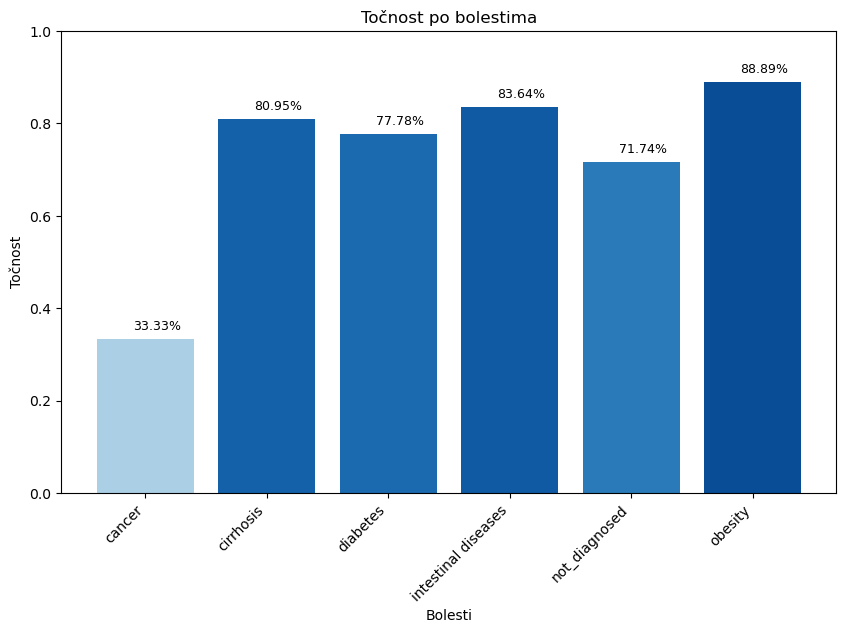

In [17]:
## Gravical display of accuracy score ##

accuracies = []

for i, class_name in enumerate(np.unique(targetEncoded)):
    indices = np.where(y_test == class_name)
    accuracy = accuracy_score(y_test[indices], y_pred[indices])
    accuracies.append(accuracy)
    correct = sum(y_test[indices] == y_pred[indices])
    total = len(y_test[indices])
    disease_name = diseases[i]

colors = plt.cm.Blues(np.array(accuracies))

plt.figure(figsize=(10, 6))
bars = plt.bar(diseases, accuracies, color=colors)
plt.xlabel('Bolesti')
plt.ylabel('Točnost')
plt.title('Točnost po bolestima')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{acc:.2%}', fontsize=9)

plt.show()

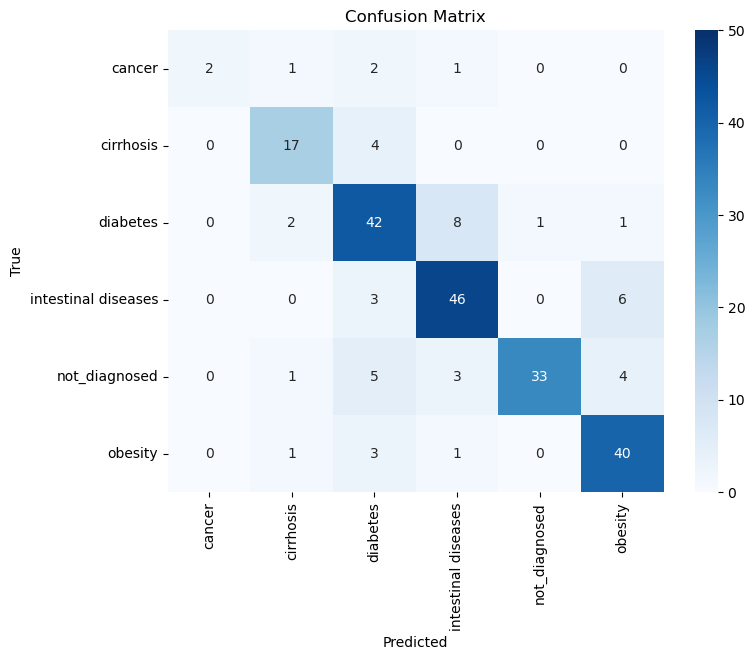

In [18]:
## Confusion matrix ##

cm = confusion_matrix(y_test, y_pred)

df_confusion_matrix = pd.DataFrame(cm, index=diseases, columns=diseases)

plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='g', vmax=50)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

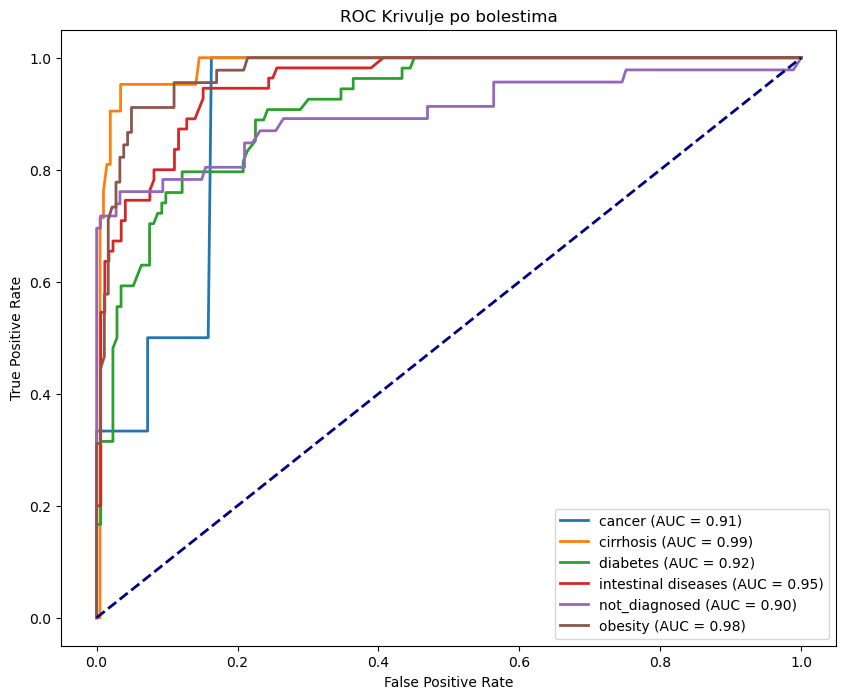

In [19]:
y_score = model.predict_proba(x_test)

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(10, 8))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i, disease_name in enumerate(diseases):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{disease_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivulje po bolestima')
plt.legend(loc="lower right")
plt.show()


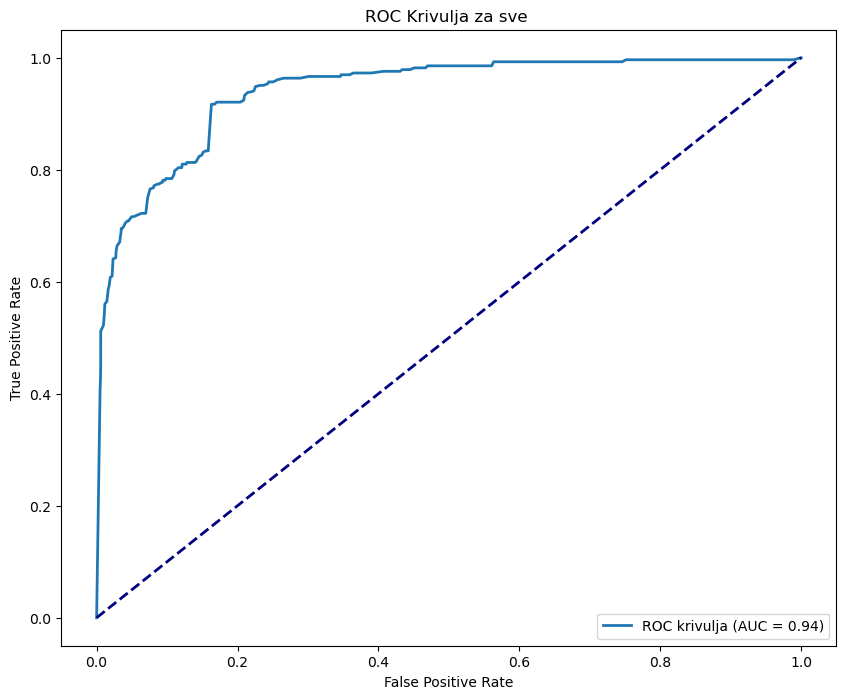

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

y_score = model.predict_proba(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(targetEncoded))):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(np.unique(targetEncoded)))]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(len(np.unique(targetEncoded))):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(np.unique(targetEncoded))

mean_tpr[0] = 0.0

roc_auc_macro = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
plt.plot(all_fpr, mean_tpr, lw=2, label=f'ROC krivulja (AUC = {roc_auc_macro:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivulja za sve ')
plt.legend(loc="lower right")
plt.show()


/usr/lib64/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 334  335  336  337  338  339  340  527  528  671  756  757  933  934
  935  936  971  972 1045 1046 1048 1049 1050 1063 1064 1066 1099 1100
 1106 1107 1124 1125 1148 1149 1150 1189 1195 1196 1218 1219 1220 1221
 1233 1234 1235 1236 1237 1282 1283 1287 1288 1289 1293 1294 1295 1296
 1299 1300 1301 1317 1318 1326 1333 1334 1351 1352 1353 1354 1355 1360
 1361 1362 1363 1379 1380 1388 1389 1390 1391 1392 1393 1394 1395 1405
 1406 1409 1410 1411 1412 1413 1414 1415 1426 1446 1447 1448 1449 1468
 1469 1478 1490 1491 1492 1493 1499 1500 1503 1504 1516 1519 1543 1554
 1555 1579 1580 1583 1584 1587 1588 1589 1590 1591 1611 1612 1613 1614
 1619 1620 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1637
 1638 1639 1640 1641 1655 1656 1671 1675 1678 1679 1682 1683 1690 1691
 1700 1701 1730 1743 1754 1757 1758 1759 1760 1770 1771 1772 1773 1774
 1775 1782 1783 1790 1791 1798 180

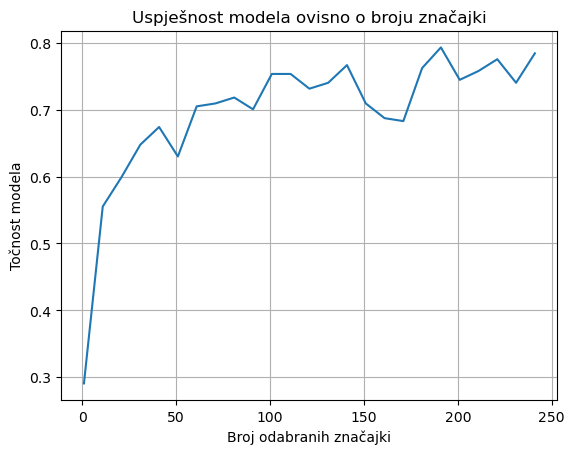

In [21]:
## Uspješnost u ovisnosti o broju stupaca ##

num_features_to_select = range(1, 251, 10)
accuracies = []

for num_features in num_features_to_select:
    selector = SelectKBest(f_classif, k=num_features)
    selected_features = selector.fit_transform(df_removed_overcorrelated, target)
    x_train, x_test, y_train, y_test = train_test_split(selected_features, targetEncoded, test_size=0.2)

    model = RandomForestClassifier(n_estimators=500)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.plot(num_features_to_select, accuracies)
plt.xlabel("Broj odabranih značajki")
plt.ylabel("Točnost modela")
plt.title("Uspješnost modela ovisno o broju značajki")
plt.grid()
plt.show()

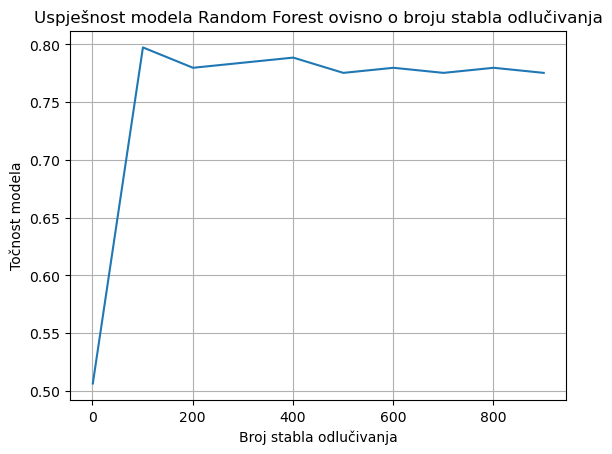

In [22]:
## Uspješnost u ovisnosti o broju stabla odlučivanja ##

num_estimators = range(1, 1001, 100)
accuracies = []

for n_estimators in num_estimators:
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(x_train, y_train)
    
    accuracy = rf_model.score(x_test, y_test)
    accuracies.append(accuracy)


plt.plot(num_estimators, accuracies)
plt.xlabel("Broj stabla odlučivanja")
plt.ylabel("Točnost modela")
plt.title("Uspješnost modela Random Forest ovisno o broju stabla odlučivanja")
plt.grid()
plt.show()